In [1]:
%load_ext tikzmagic
%matplotlib inline

# 예측과 교차검증

회귀분석의 첫번째 목적은 종속변수와 독립변수간의 관계, 즉 가중치를 알아내는 것이다. 회귀분석의 두번째 목적은 이 가중치를 사용하여 새로운 독립변수 값에 대한 종속변수를 예측하는 것이다. 이 절에서는 새로운 종속변수를 예측하는 방법에 대해 알아본다.

## 예측

예제 회귀분석모형으로 보스턴 집값 데이터를 lstat 독립변수로 예측하는 간단한 모형을 사용하여 설명한다.

In [2]:
import statsmodels.api as sm

boston = sm.datasets.get_rdataset("Boston", "MASS").data

formula = "medv ~ scale(lstat)"
model = sm.OLS.from_formula(formula, boston)
result = model.fit()

선형회귀분석 결과 객체는 종속변수를 예측하는 `get_prediction` 메서드를 제공한다. `get_prediction` 메서드의 입력값으로는 독립변수 값이 있는 pands 데이터프레임을 넣어야 한다. lstat의 값이 각각 5, 6, 7인 경우의 집값을 예측해보자.

In [3]:
import pandas as pd

X_new = pd.DataFrame({"lstat": [5, 6, 7]})
X_new

,lstat
0,5
1,6
2,7


이 독립변수 데이터를 넣어서 `get_prediction` 메서드를 호출하면 예측 객체가 나온다. 예측 객체는 `PredictionResults` 클래스 객체다.

In [4]:
pred_result = result.get_prediction(X_new)
pred_result

이 예측 객체의 `summary_frame` 메서드를 호출하면 예측 결과를 데이터프레임으로 출력한다.

In [5]:
df_pred = pred_result.summary_frame()
df_pred

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.803594,0.405247,29.007412,30.599776,17.565675,42.041513
1,28.853545,0.377839,28.111211,29.595878,16.619011,41.088079
2,27.903495,0.352562,27.210824,28.596167,15.671874,40.135117


예측 결과에서 `mean` 열이 예측된 종속변수 값이다. 

이와 같이 선형회귀분석에 사용되지 않은 새로운 독립변수 값을 넣어서 종속변수를 예측하는 것을 <b>표본 외 예측(out-of-sample prediction)</b>이라고 한다. 이와 다르게 이미 선형회귀분석에 사용되었던 데이터를 다시 모형에 넣어서 종속변수를 예측하는 것은 <b>표본 내 예측(in-sample prediction)</b>이라고 한다. 

다음은 표본 내 예측을 하는 코드다.

In [6]:
pred_result_insample = result.get_prediction(boston)
df_pred_insample = pred_result_insample.summary_frame()
df_pred_insample

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.822595,0.405814,29.025299,30.619891,17.584603,42.060587
1,25.870390,0.308011,25.265246,26.475534,13.643413,38.097367
2,30.725142,0.433488,29.873477,31.576807,18.483488,42.966796
3,31.760696,0.466794,30.843594,32.677798,19.514315,44.007076
4,29.490078,0.395994,28.712077,30.268079,17.253328,41.726828
...,...,...,...,...,...,...
501,25.366864,0.299509,24.778424,25.955303,13.140702,37.593025
502,25.927393,0.309045,25.320218,26.534568,13.700315,38.154470
503,29.195563,0.387483,28.434281,29.956844,16.959864,41.431261
504,28.397521,0.365412,27.679603,29.115439,16.164444,40.630598


사실 표본 내 예측값은 분석결과 객체 내부에 `fittedvalues` 속성으로 이미 계산되어 있으므로 이렇게 계산할 필요는 없다.

In [7]:
result.fittedvalues

0      29.822595
1      25.870390
2      30.725142
3      31.760696
4      29.490078
         ...    
501    25.366864
502    25.927393
503    29.195563
504    28.397521
505    27.067452
Length: 506, dtype: float64

## 예측신뢰구간

다음으로 예측 오차를 나타내는 <b>예측신뢰구간(prediction confidence interval)</b>을 계산해보자. 예측신뢰구간이란 정해진 확률로 종속변수 값이나 종속변수 값의 평균이 존재할 범위를 뜻한다. 예측신뢰구간에는 두 종류가 있다. 

* 평균 예측신뢰구간(mean prediction confidence interval)
* 관측 예측신뢰구간(observation prediction confidence interval)

평균 예측신뢰구간은 우리가 구한 가중치의 추정값이 정확한 가중치가 아니기 때문에 발생하는 예측값의 오차 범위를 뜻한다. 관측 예측신뢰구간은 예측값이 아니라 실제 종속변수 데이터가 나타날 수 있는 범위를 뜻한다. 즉, 가중치의 오차 뿐 아니라 교란항으로 인해 생기는 오차까지 포함하는 것이므로 관측 예측신뢰구간이 평균 예측신뢰구간보다 크다.

우선 평균 예측신뢰구간부터 살펴보자. 앞 절에서 가중치 검정을 위해 사용하였던 확률론적 가정들을 사용하면 가중치의 오차로 인해 예측값이 스튜던트t 확률분포를 따르는 것을 증명할 수 있다. 이 때 예측값 확률분포의 평균은 예측모형으로 구한 예측값이다.

$$
\text{E}\left[\hat{y}(x_{\text{new}})\right] = \hat{y} = \hat{w}_0 + \hat{w}_1 \cdot x_{\text{new}}
$$

예측값 확률분포의 분산은 별도의 수식으로 구한다. 다음 수식은 1개의 독립변수만 가지는 선형회귀분석 모형에서 새로운 독립변수값 $x$에 대한 예측값 확률분포의 분산을 구하는 수식이다. 독립변수가 2개 이상인 경우는 더 복잡한 수식을 사용하므로 여기에서는 생략한다.

$$
\text{Var}\left[\hat{y}(x_{\text{new}})\right] = \frac{RSS \cdot N}{N-2}\left( 1 + \dfrac{1}{N} + \frac{(x_{\text{new}} - \bar{x})^2}{s^2_x} \right)
$$

이 식에서 $\bar{x}$는 회귀분석에 사용한 독립변수 데이터의 평균이고 $s^2_x$는 회귀분석에 사용한 독립변수 데이터의 분산이다. 이렇게 구한 예측값 확률분포의 평균과 분산을 이용하여 예측신뢰구간을 구할 수 있다.

위 식을 자세히 보면 예측하고자 하는 독립변수의 값 $x_{\text{new}}$이 회귀분석에 사용한 독립변수 데이터의 평균으로부터 멀어질수록 예측값 확률분포의 분산이 커지는 것을 알 수 있다. 예측값 확률분포의 분산이 커진다는 것은 예측신뢰구간이 넓어지고 예측의 정확도가 떨어진다는 뜻이다.

앞에서 예측 객체의 `summary_frame` 메서드를 호출했을 때 나온 데이터프레임 중  `mean_ci_upper`, `mean_ci_lower` 열이 평균 예측신뢰구간의 상한과 하한을 나타내는 값이다. `obs_ci_lower`, `obs_ci_upper` 열은 관측 예측신뢰구간의 상한과 하한을 나타낸다. 

그림으로 표시하면 다음과 같다.

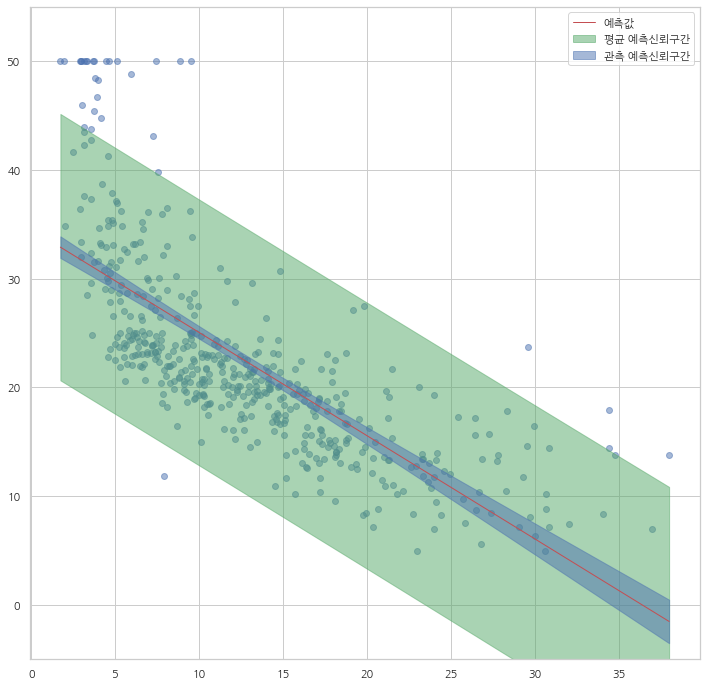

In [8]:
x = boston.lstat.sort_values().values
idx = boston.lstat.sort_values().index
y = boston.medv[idx]
y_hat = df_pred_insample["mean"][idx]
y_m_upper = df_pred_insample["mean_ci_upper"][idx]
y_m_lower = df_pred_insample["mean_ci_lower"][idx]
y_o_upper = df_pred_insample["obs_ci_upper"][idx]
y_o_lower = df_pred_insample["obs_ci_lower"][idx]

plt.figure(figsize=(12, 12))
plt.scatter(x, y, alpha=0.5)
plt.plot(x, y_hat, c="r", lw=1, label="예측값")
plt.fill_between(x, y_o_upper, y_o_lower, color="g", alpha=0.5, label="평균 예측신뢰구간")
plt.fill_between(x, y_m_upper, y_m_lower, color="b", alpha=0.5, label="관측 예측신뢰구간")
plt.ylim(-5, 55)
plt.legend()
plt.show()

seaborn 패키지의 `regplot` 함수를 사용하면 더 간단하게 평균 예측신뢰구간을 그릴 수 있다.

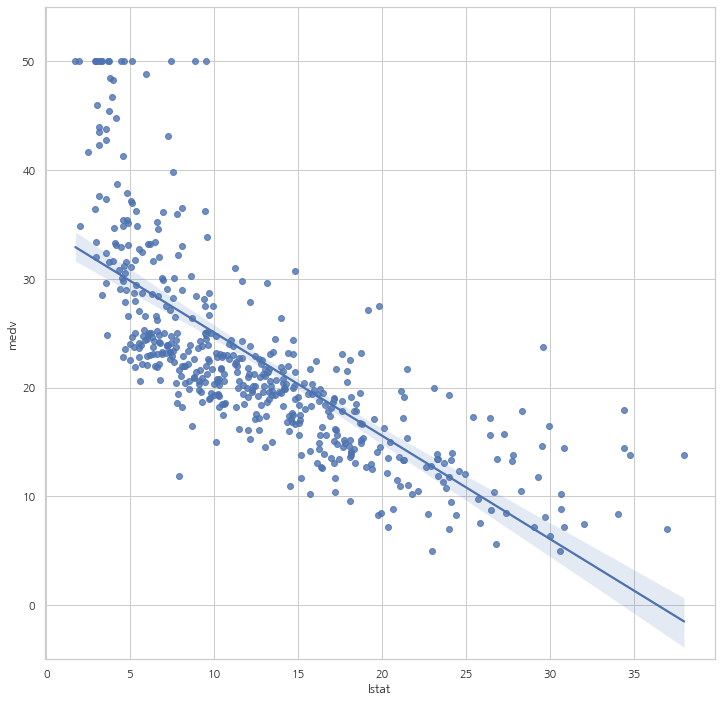

In [11]:
plt.figure(figsize=(12, 12))
sns.regplot(x="lstat", y="medv", data=boston)
plt.ylim(-5, 55)
plt.show()

`summary_frame` 메서드로 예측신뢰구간을 구할 때 사용하는 확률은 기본적으로 95%다. 만약 다른 확률값을 지정하고 싶다면 `summary_frame` 메서드의 입력변수로 (1 - 확률)의 값을 넣어준다.

다음 그림은 99% 확률 예측신뢰구간을 그린 것이다. 확률이 높아진 만큼 이를 맞추기 위해 범위가 넓어진 것을 확인할 수 있다.

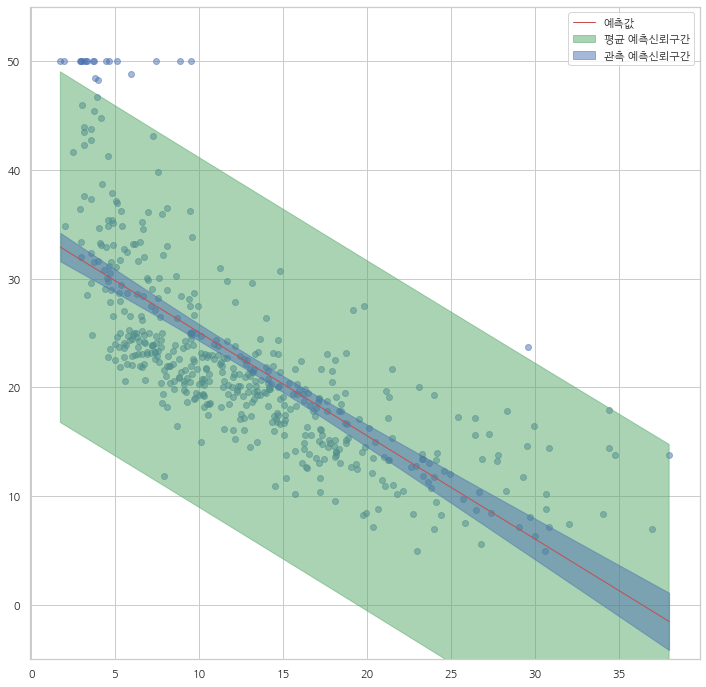

In [10]:
df_pred_insample2 = pred_result_insample.summary_frame(1 - 0.99)

y_m_upper = df_pred_insample2["mean_ci_upper"][idx]
y_m_lower = df_pred_insample2["mean_ci_lower"][idx]
y_o_upper = df_pred_insample2["obs_ci_upper"][idx]
y_o_lower = df_pred_insample2["obs_ci_lower"][idx]

plt.figure(figsize=(12, 12))
plt.scatter(x, y, alpha=0.5)
plt.plot(x, y_hat, c="r", lw=1, label="예측값")
plt.fill_between(x, y_o_upper, y_o_lower, color="g", alpha=0.5, label="평균 예측신뢰구간")
plt.fill_between(x, y_m_upper, y_m_lower, color="b", alpha=0.5, label="관측 예측신뢰구간")
plt.ylim(-5, 55)
plt.legend()
plt.show()

## 교차검증